# Project: Decoding Molecules From Fingerprints.
## Group Members:
### Qi Chen, e-mail: gusqichr@student.gu.se
### Nils Dunlop, e-mail: gusdunlni@student.gu.se
### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se
***

In [147]:
import os
import io
import base64
from typing import List, Tuple
from concurrent.futures import ThreadPoolExecutor, as_completed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors as mcolors
from PIL import Image
from collections import defaultdict
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import spearmanr

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit import DataStructs
from rdkit.DataStructs import TanimotoSimilarity
import requests
import time
import pandas as pd
from typing import Optional, List, Dict
from datetime import datetime
import urllib.parse
from IPython.display import display
from ipywidgets import interact, fixed, widgets

from joblib import Parallel, delayed
from sklearn.manifold import MDS, TSNE

# Pandas display settings
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

### Define directories
***

In [148]:
# Set user directory
USER_DIR = os.path.expanduser('~')

# Set the project root directory
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Define the input and output directories
INPUT_DIR = os.path.join(PROJECT_ROOT, 'data/bit_flipping_nn_review_1')
INPUT_DIR2 = os.path.join(PROJECT_ROOT, 'data/bit_flipping_nn')

### Load Parecoxib, Celecoxib, Cimicoxib and Deracoxib, Anitrazafen Data
***

In [149]:


anitrazafen_df_2048 = pd.read_parquet(os.path.join(INPUT_DIR2, 'anitrazafen_flipped_df.parquet'))
print(f"Anitrazafen shape: {anitrazafen_df_2048.shape}")

Anitrazafen shape: (2048, 9)


### Validate generated SMILES
***

In [150]:
# Function to convert SMILES to molecule and check validity
def smiles_to_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None, mol

In [151]:

anitrazafen_df_2048['Valid_SMILES'], anitrazafen_df_2048['Molecule'] = zip(*anitrazafen_df_2048['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))


In [152]:
def calculate_valid_smiles_percentage(df_dict):
    results = []
    
    for compound, df in df_dict.items():
        valid_smiles = df['Valid_SMILES'].sum()
        percentage = df['Valid_SMILES'].mean() * 100
        results.append({
            'Compound': compound,
            'Valid_SMILES': valid_smiles,
            'Percentage': percentage
        })
    
    return pd.DataFrame(results)

### Generate ECFP4 Fingerprints of Generated SMILES
***

In [153]:
def generate_fingerprints_for_predictions_dict(df_dict, n_jobs=-1):
    """
    Generate ECFP4 fingerprints for predicted SMILES strings using parallel processing.
    """
    def process_single_smiles(smiles):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            morgan_generator = GetMorganGenerator(radius=2, fpSize=2048)
            fp = morgan_generator.GetFingerprint(mol)
            bit_vector = np.array(list(fp.ToBitString())).astype(int)
            sparse_representation = list(np.where(bit_vector == 1)[0])
            sparse_representation_str = ' '.join(map(str, sparse_representation))
            return bit_vector, sparse_representation_str
        return None, None

    updated_dict = {}
    
    for molecule_name, df in df_dict.items():
        print(f"Processing {molecule_name}...")
        
        # Use parallel processing to generate fingerprints
        with ThreadPoolExecutor(max_workers=n_jobs if n_jobs > 0 else None) as executor:
            results = list(executor.map(process_single_smiles, df['Generated_SMILES']))
        
        # Split results into separate lists
        bit_vectors, sparse_representations = zip(*results)
        
        # Create a copy of the DataFrame and add the new columns
        df_copy = df.copy()
        df_copy['GeneratedFingerprintBits'] = bit_vectors
        df_copy['GeneratedFingerprintSparse'] = sparse_representations
        
        # Store updated DataFrame in new dictionary
        updated_dict[molecule_name] = df_copy
    
    return updated_dict

def compare_fingerprints_dict(df_dict):
    """
    Compare original and generated fingerprints to verify they're different.
    """
    results = {}
    
    for molecule_name, df in df_dict.items():
        different_fps = df.apply(
            lambda row: not np.array_equal(row['FingerprintBitsFlipped'], 
                                         row['GeneratedFingerprintBits']), 
            axis=1
        ).sum()
        
        total = len(df)
        results[molecule_name] = {
            'different_fps': different_fps,
            'total': total,
            'percentage': (different_fps/total) * 100
        }
        
    return results

In [154]:
anitrazafen_df_2048 = generate_fingerprints_for_predictions_dict({'Anitrazafen': anitrazafen_df_2048})['Anitrazafen']

# Compare results for each dataset
for n_flips, dfs in [
    (2048, [anitrazafen_df_2048])
]:
    print(f"\nResults for {n_flips} flips:")
    for df, name in zip(dfs, ['Anitrazafen']):
        different_fps = df.apply(
            lambda row: not np.array_equal(row['FingerprintBitsFlipped'], 
                                         row['GeneratedFingerprintBits']), 
            axis=1
        ).sum()
        total = len(df)
        percentage = (different_fps/total) * 100
        print(f"{name}: {different_fps}/{total} fingerprints are different ({percentage:.2f}%)")

Processing Anitrazafen...

Results for 2048 flips:
Anitrazafen: 2047/2048 fingerprints are different (99.95%)


### Tanimoto similarity
***

In [155]:
def calculate_tanimoto_safe(fp_bits1, fp_bits2):
    """
    Calculate Tanimoto similarity between two fingerprint bit vectors.
    """
    try:
        # Convert bit vectors to numpy arrays if they aren't already
        fp_bits1 = np.array(fp_bits1)
        fp_bits2 = np.array(fp_bits2)
        
        # Verify that both fingerprints have the same length
        if len(fp_bits1) != len(fp_bits2):
            print(f"Fingerprint lengths don't match: {len(fp_bits1)} vs {len(fp_bits2)}")
            return None
            
        # Calculate intersection (AND) and union (OR)
        intersection = np.sum(fp_bits1 & fp_bits2)
        union = np.sum(fp_bits1 | fp_bits2)
        
        # Avoid division by zero
        if union == 0:
            print("Warning: Union of fingerprints is zero")
            return 0.0
            
        # Calculate Tanimoto similarity
        tanimoto = intersection / union
        
        return float(tanimoto)
        
    except Exception as e:
        print(f"Error calculating Tanimoto similarity: {e}")
        return None

In [156]:

anitrazafen_df_2048['Tanimoto'] = anitrazafen_df_2048.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['FingerprintBitsFlipped']), axis=1)

In [157]:

anitrazafen_df_2048['Tanimoto2'] = anitrazafen_df_2048.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['GeneratedFingerprintBits']), axis=1)

In [158]:
def print_average_similarities_single(flip_count):
    """
    Calculate and print average Tanimoto similarities for both flipped fingerprints and generated SMILES
    for single bit flips.
    """
    molecules = ['anitrazafen']
    
    print(f'\n*** {flip_count} random single flips ***')
    
    # Print Tanimoto similarities for flipped fingerprints
    print("--- Tanimoto Similarity (Flipped Fingerprints) ---")
    for molecule in molecules:
        df = globals()[f'{molecule}_df_{flip_count}']
        avg_similarity = df['Tanimoto'].mean()
        print(f"Average Tanimoto Similarity for {flip_count} random single flips {molecule.capitalize()}: {avg_similarity}")
    
    # Print Tanimoto similarities for generated SMILES
    print("\n--- Tanimoto Similarity (Generated SMILES) ---")
    for molecule in molecules:
        df = globals()[f'{molecule}_df_{flip_count}']
        avg_similarity2 = df['Tanimoto2'].mean()
        print(f"Average Tanimoto2 Similarity for {flip_count} random single flips {molecule.capitalize()}: {avg_similarity2}")

In [159]:
# Calculate and print similarities for each flip count
for flips in [2048]:
    print_average_similarities_single(flips)


*** 2048 random single flips ***
--- Tanimoto Similarity (Flipped Fingerprints) ---
Average Tanimoto Similarity for 2048 random single flips Anitrazafen: 0.9629448784722224

--- Tanimoto Similarity (Generated SMILES) ---
Average Tanimoto2 Similarity for 2048 random single flips Anitrazafen: 0.9977726688437247


In [160]:
def plot_similarity_distribution(df, molecule_name, n_flips):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
    # Plot Tanimoto (Flipped Fingerprints)
    sns.histplot(data=df['Tanimoto'], bins=20, kde=True, ax=ax1)
    ax1.set_title(f'Similarity Distribution (Flipped Fingerprints)\n{molecule_name} ({n_flips} flips)')
    ax1.set_xlabel('Tanimoto Similarity')
    ax1.set_ylabel('Count')
    
    # Plot Tanimoto2 (Generated SMILES)
    sns.histplot(data=df['Tanimoto2'], bins=20, kde=True, ax=ax2)
    ax2.set_title(f'Similarity Distribution (Generated SMILES)\n{molecule_name} ({n_flips} flips)')
    ax2.set_xlabel('Tanimoto Similarity')
    ax2.set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()

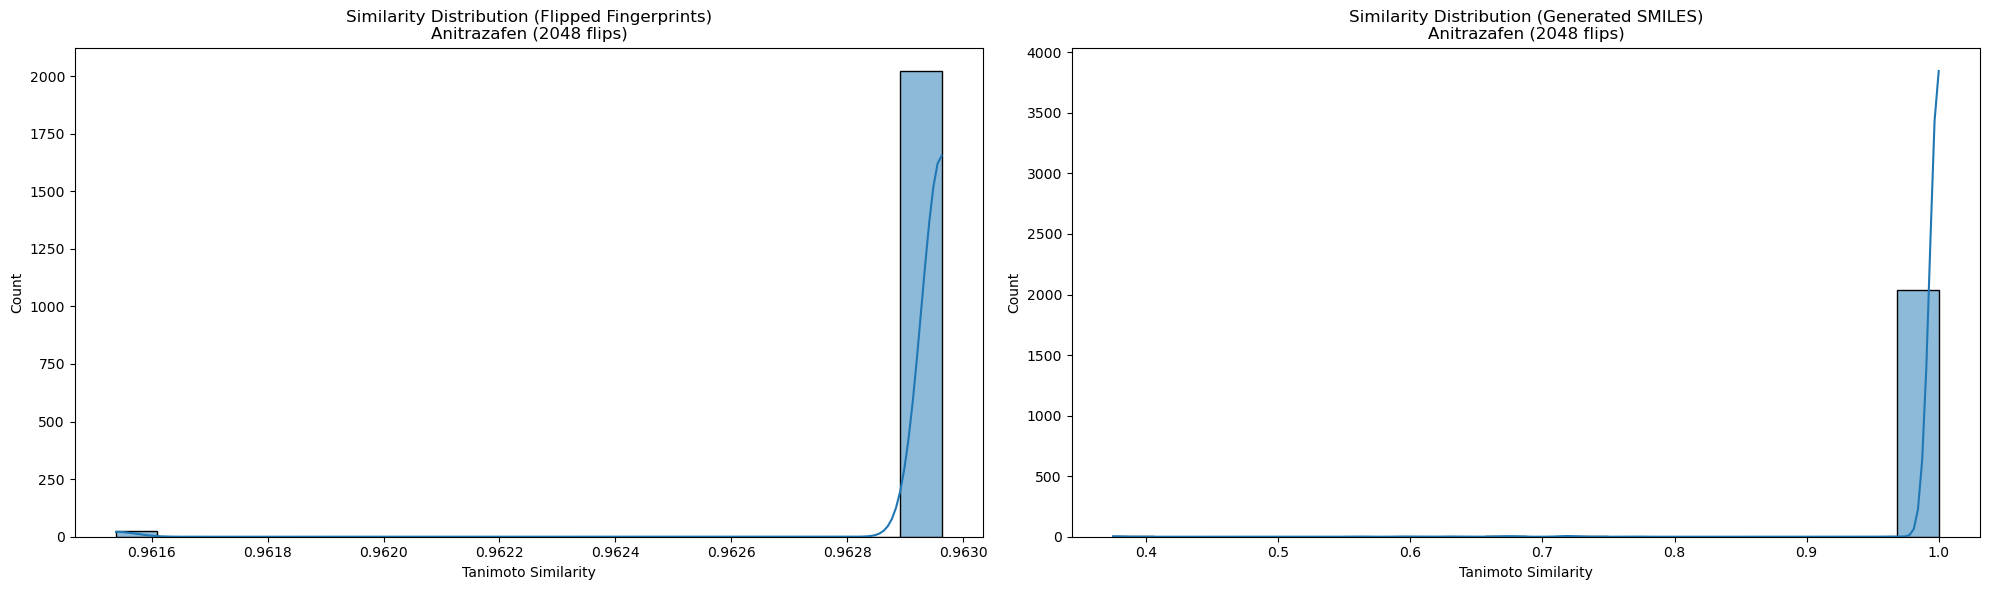

In [161]:
plot_similarity_distribution(anitrazafen_df_2048, 'Anitrazafen', 2048)

### Compare generated SMILES
***

In [162]:
def analyze_smiles_occurrences(df_2048, compound_name):
    # Get value counts for the dataset
    smiles_counts_2048 = df_2048['Generated_SMILES'].value_counts().to_dict()
    
    # Create result dictionary
    results = {
        'compound_name': compound_name,
        'datasets': {
            '2048_flips': {
                'occurrences': smiles_counts_2048,
                'total_unique': len(smiles_counts_2048),
                'total_samples': len(df_2048)
            }
        }
    }
    
    return results

# The print function remains the same as it will automatically handle the new dataset
def print_smiles_analysis(results):
    compound_name = results['compound_name']
    print(f"\n**** {compound_name} ****")
    
    for dataset_name, dataset_info in results['datasets'].items():
        print(f"\n--- {dataset_name} ---")
        print(f"Total unique SMILES: {dataset_info['total_unique']}")
        print(f"Total samples: {dataset_info['total_samples']}")
        print("SMILES occurrences:")
        
        # Sort by occurrence count (descending) and print
        sorted_smiles = sorted(dataset_info['occurrences'].items(), key=lambda x: (-x[1], x[0]))
        
        for smiles, count in sorted_smiles:
            print(f"Count: {count} - SMILES: {smiles}")

In [163]:
anitrazafen_results = analyze_smiles_occurrences(anitrazafen_df_2048, "Anitrazafen")
print_smiles_analysis(anitrazafen_results)



**** Anitrazafen ****

--- 2048_flips ---
Total unique SMILES: 14
Total samples: 2048
SMILES occurrences:
Count: 2034 - SMILES: COc1ccc(-c2nnc(C)nc2-c2ccc(OC)cc2)cc1
Count: 2 - SMILES: COc1ccc(-c2nnc(-c3ccc(OC)cc3)c3nc(C)nnc23)cc1
Count: 1 - SMILES: COC1=NC(c2ccc(OC)cc2)=C(c2ccc(OC)cc2)N=C(C)N1
Count: 1 - SMILES: COc1ccc(-c2ccc(-c3nnc(C)nc3-c3ccc(OC)cc3)cc2)cc1
Count: 1 - SMILES: COc1ccc(-c2nc(C)nc(-c3ccc(OC)cc3)c2C)cc1
Count: 1 - SMILES: COc1ccc(-c2nc(C)nc3nc(C)nnc23)cc1
Count: 1 - SMILES: COc1ccc(-c2nc(C)nnc2C)cc1
Count: 1 - SMILES: COc1ccc(-c2nc3nnc(C)nc3nc2-c2ccc(OC)cc2)cc1
Count: 1 - SMILES: COc1ccc(-c2nnc(-c3ccc(OC)cc3)c3c(-c4ccc(OC)cc4)nc(C)nc23)cc1
Count: 1 - SMILES: COc1ccc(-c2nnc(C)nc2-c2ccc(-c3nnc(C)nc3-c3ccc(OC)cc3)cc2)cc1
Count: 1 - SMILES: COc1ccc(-c2nnc(OC)nc2-c2ccc(OC)cc2)cc1
Count: 1 - SMILES: COc1ccc(-c2nnc3c(-c4ccc(OC)cc4)nc(C)nc3c2-c2ccc(OC)cc2)cc1
Count: 1 - SMILES: COc1ccc(-c2nnnc(C)n2)cc1
Count: 1 - SMILES: COc1ccc(C2=C3N=C(C)N=C3N=N2)cc1


### Plot generated molecules
***

In [164]:
def mol_to_image(mol):
    if isinstance(mol, str):
        mol = Chem.MolFromSmiles(mol)
    if mol is None:
        return None
    img = Draw.MolToImage(mol)
    buffered = io.BytesIO()
    img.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode()

def plot_unique_molecules(df, n_flips):
    molecule_name = df.iloc[0]['title'].lower()
    
    # Create a new column in df to store the original index
    df['original_index'] = df.index

    # Remove duplicates based on 'Generated_SMILES' but keep original indices
    df_unique = df.drop_duplicates(subset=['Generated_SMILES']).copy()
    
    n_rows = len(df_unique) + 1  # +1 for the original molecule
    fig, axes = plt.subplots(n_rows, 1, figsize=(10, 5*n_rows))
    
    # Plot original molecule
    original_mol = Chem.MolFromSmiles(df.iloc[0]['SMILES'])
    img = Draw.MolToImage(original_mol)
    axes[0].imshow(img)
    axes[0].set_title(f"Original Molecule: {df.iloc[0]['title']}\nSMILES: {df.iloc[0]['SMILES']}")
    axes[0].axis('off')
    
    # Plot unique generated molecules
    for i, row in enumerate(df_unique.iterrows(), start=1):
        img = mol_to_image(row[1]['Generated_SMILES'])
        if img:
            axes[i].imshow(Image.open(io.BytesIO(base64.b64decode(img))))
            axes[i].set_title(f"Generated Molecule {row[1]['original_index']} (Flipped Bits: {row[1]['FlippedBitPosition']})\n"
                              f"SMILES: {row[1]['Generated_SMILES']}\n"
                              f"Tanimoto = {row[1].get('Tanimoto2', 'N/A'):.2f}")
        else:
            axes[i].text(0.5, 0.5, "Invalid SMILES", ha='center', va='center')
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(INPUT_DIR, f'{molecule_name}_{n_flips}_unique_flips.png'))
    plt.close(fig)

In [165]:
plot_unique_molecules(anitrazafen_df_2048,2048)

### Plot the nearest neighbors
***

In [166]:
def generate_fingerprints(smiles_list):
    """Generate Morgan fingerprints for a list of SMILES strings."""
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    morgan_generator = GetMorganGenerator(radius=2, fpSize=2048)
    fps = [morgan_generator.GetFingerprint(mol) for mol in mols if mol is not None]
    return fps


def calculate_similarity_matrix(fps):
    """Calculate Tanimoto similarity matrix for a list of fingerprints."""
    n = len(fps)
    similarity_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            similarity_matrix[i, j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])
    return similarity_matrix

def plot_mds_similarity(df, title_column='title', smiles_column='SMILES', 
                        generated_smiles_column='Generated_SMILES', n_flips=10):
    """Plot MDS similarity for molecules in the dataframe with a color bar indicating similarity to the original."""
    # Extract SMILES (original + generated)
    original_smiles = df[smiles_column].iloc[0]
    all_smiles = [original_smiles] + df[generated_smiles_column].tolist()

    # Generate fingerprints and calculate similarity matrix
    fps = generate_fingerprints(all_smiles)
    similarity_matrix = calculate_similarity_matrix(fps)

    # Apply MDS
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    coords = mds.fit_transform(1 - similarity_matrix)  # Convert similarity to distance
    #coords = mds.fit_transform(1 - similarity_matrix + 1e-8)  # Convert similarity to distance, epsilon to avoid divison by zero


    # Calculate similarities to the original molecule
    similarities_to_original = similarity_matrix[0, 1:]

    # Plot
    plt.figure(figsize=(14, 10))
    
    # Plot generated SMILES with color indicating similarity to original
    scatter = plt.scatter(coords[1:, 0], coords[1:, 1], c=similarities_to_original, 
                          cmap='viridis', alpha=0.6, s=100)
    
    # Plot original SMILES in red
    plt.scatter(coords[0, 0], coords[0, 1], c='red', s=200, label='Original SMILES', edgecolors='black')

    # Add color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Tanimoto Similarity to Original', rotation=270, labelpad=20)

    # Add labels
    for i, smiles in enumerate(all_smiles):
        label = "Original" if i == 0 else f"{df['FlippedBitPosition'].iloc[i-1]}"
        plt.annotate(label, (coords[i, 0], coords[i, 1]), xytext=(5, 5), 
                     textcoords='offset points', fontsize=8)

    plt.title(f"2D Projection of Molecular Similarity for {df[title_column].iloc[0]} ({n_flips} flips)")
    plt.xlabel("MDS Dimension 1")
    plt.ylabel("MDS Dimension 2")
    plt.legend()
    plt.tight_layout()
    
    # Save the figure
    filename = f'{df[title_column].iloc[0].lower()}_{n_flips}_flips_mds_similarity.png'
    plt.savefig(os.path.join(INPUT_DIR, filename))
    plt.close()


def process_and_plot(df, n_flips):
    """Process dataframe and generate plot with error handling."""
    try:
        success = plot_mds_similarity(df, n_flips=n_flips)
        if success:
            print(f"MDS plot saved for {df['title'].iloc[0]} with {n_flips} flips.")
        else:
            print(f"Failed to create MDS plot for data with {n_flips} flips.")
    except Exception as e:
        print(f"Error in process_and_plot with {n_flips} flips: {str(e)}")

In [167]:
process_and_plot(anitrazafen_df_2048, 2048)

Failed to create MDS plot for data with 2048 flips.


In [168]:
anitrazafen_df_2048.columns

Index(['title', 'SMILES', 'FingerprintBits', 'SparseFingerprintBits',
       'FingerprintBitsFlipped', 'SparseFingerprintBitsFlipped',
       'FlippedBitPosition', 'Generated_SMILES', 'Device_Used', 'Valid_SMILES',
       'Molecule', 'GeneratedFingerprintBits', 'GeneratedFingerprintSparse',
       'Tanimoto', 'Tanimoto2', 'original_index'],
      dtype='object')

In [169]:
def plot_tsne_similarity(df, title_column='title', smiles_column='SMILES', 
                         generated_smiles_column='Generated_SMILES', n_flips=10):
    """Plot t-SNE similarity for molecules in the dataframe with a color bar indicating similarity to the original."""
    # Extract SMILES (original + generated)
    original_smiles = df[smiles_column].iloc[0]  # Assuming all rows have the same original SMILES
    all_smiles = [original_smiles] + df[generated_smiles_column].tolist()

    # Generate fingerprints and calculate similarity matrix
    fps = generate_fingerprints(all_smiles)
    similarity_matrix = calculate_similarity_matrix(fps)

    # Adjust perplexity based on number of samples
    n_samples = len(all_smiles)
    perplexity = min(30, n_samples - 1)  # Default is 30, but we need it to be less than n_samples

    # Apply t-SNE
    tsne = TSNE(n_components=2, metric='precomputed', random_state=42, 
                perplexity=perplexity, init='random', learning_rate='auto')
    coords = tsne.fit_transform(1 - similarity_matrix)  # Convert similarity to distance

    # Calculate similarities to the original molecule
    similarities_to_original = similarity_matrix[0, 1:]

    # Plot
    plt.figure(figsize=(14, 10))
    
    # Plot generated SMILES with color indicating similarity to original
    scatter = plt.scatter(coords[1:, 0], coords[1:, 1], c=similarities_to_original, 
                          cmap='viridis', alpha=0.6, s=100)
    
    # Plot original SMILES in red
    plt.scatter(coords[0, 0], coords[0, 1], c='red', s=200, label='Original SMILES', edgecolors='black')

    # Add color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Tanimoto Similarity to Original', rotation=270, labelpad=20)

    # Add labels
    for i, smiles in enumerate(all_smiles):
        label = "Original" if i == 0 else f"{df['FlippedBitPosition'].iloc[i-1]}"
        plt.annotate(label, (coords[i, 0], coords[i, 1]), xytext=(5, 5), 
                     textcoords='offset points', fontsize=8)

    plt.title(f"2D Projection of Molecular Similarity for {df[title_column].iloc[0]} ({n_flips} flips)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.tight_layout()
    
    # Save the figure
    filename = f'{df[title_column].iloc[0].lower()}_{n_flips}_flips_tsne_similarity.png'
    plt.savefig(os.path.join(INPUT_DIR, filename))
    plt.close()

# The process_and_plot_tsne function remains the same
def process_and_plot_tsne(df, n_flips):
    plot_tsne_similarity(df, n_flips=n_flips)
    print(f"t-SNE plot saved for {df['title'].iloc[0]} with {n_flips} flips.")

In [170]:
process_and_plot_tsne(anitrazafen_df_2048, 2048)


t-SNE plot saved for Anitrazafen with 2048 flips.


### Bits Analysis
---

In [171]:
dataframes_dict = {
    'anitrazafen': {
        2048: anitrazafen_df_2048
    }
}

In [172]:
def analyze_bit_similarities(df, molecule_name, n_flips):
    """
    Analyze similarities for each bit position and create detailed summary
    """
    bit_analysis = defaultdict(lambda: {
        'similarities': [],
        'count': 0,
        'avg_similarity': 0,
        'std_similarity': 0,
        'min_similarity': 1,
        'max_similarity': 0,
        'molecule': molecule_name,
        'n_flips': n_flips
    })
    
    # Get original molecule for structure analysis
    original_smiles = df['SMILES'].iloc[0]
    mol = Chem.MolFromSmiles(original_smiles)
    info = {}
    # Generate Morgan fingerprint and get bit info
    AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048, bitInfo=info)
    
    # Analyze each bit flip
    for idx, row in df.iterrows():
        bit = row['FlippedBitPosition']
        similarity = row['Tanimoto']
        
        bit_analysis[bit]['similarities'].append(similarity)
        bit_analysis[bit]['count'] += 1
        bit_analysis[bit]['min_similarity'] = min(bit_analysis[bit]['min_similarity'], similarity)
        bit_analysis[bit]['max_similarity'] = max(bit_analysis[bit]['max_similarity'], similarity)
        
        # Add structural information if available
        if bit in info:
            bit_analysis[bit]['substructures'] = info[bit]
    
    # Calculate statistics
    for bit, data in bit_analysis.items():
        similarities = data['similarities']
        data['avg_similarity'] = np.mean(similarities)
        data['std_similarity'] = np.std(similarities) if len(similarities) > 1 else 0
    
    return bit_analysis

def generate_bit_impact_report(dataframes_dict):
    """
    Generate comprehensive report comparing bit impacts across molecules and flip counts
    """
    all_analyses = {}
    summary_stats = []
    
    # Analyze each molecule and flip count combination
    for molecule, flip_dict in dataframes_dict.items():
        for n_flips, df in flip_dict.items():
            try:
                analysis = analyze_bit_similarities(df, molecule, n_flips)
                key = f"{molecule}_{n_flips}"
                all_analyses[key] = analysis
                
                # Create DataFrame for this analysis
                analysis_df = pd.DataFrame([{
                    'Molecule': molecule,
                    'N_Flips': n_flips,
                    'Bit_Position': bit,
                    'Average_Similarity': data['avg_similarity'],
                    'Std_Similarity': data['std_similarity'],
                    'Min_Similarity': data['min_similarity'],
                    'Max_Similarity': data['max_similarity'],
                    'Times_Flipped': data['count'],
                    'Has_Structural_Info': 'Yes' if 'substructures' in data else 'No',
                    'Structural_Info': str(data.get('substructures', ''))
                } for bit, data in analysis.items()])
                
                # Get summary statistics
                top_bits = analysis_df.nsmallest(10, 'Average_Similarity')
                bottom_bits = analysis_df.nlargest(10, 'Average_Similarity')
                
                summary_stats.append({
                    'Molecule': molecule,
                    'N_Flips': n_flips,
                    'Most_Impactful_Bits': top_bits['Bit_Position'].tolist(),
                    'Least_Impactful_Bits': bottom_bits['Bit_Position'].tolist(),
                    'Avg_Similarity': analysis_df['Average_Similarity'].mean(),
                    'Std_Similarity': analysis_df['Average_Similarity'].std()
                })
            except Exception as e:
                print(f"Error processing {molecule} with {n_flips} flips: {str(e)}")
                continue
    
    summary_df = pd.DataFrame(summary_stats)
    return all_analyses, summary_df

def analyze_single_molecule(dataframes_dict, molecule_name, n_flips):
    """
    Detailed analysis of a single molecule's fingerprint bits
    """
    df = dataframes_dict[molecule_name.lower()][n_flips]
    analysis = analyze_bit_similarities(df, molecule_name, n_flips)
    
    # Get original molecule
    original_smiles = df['SMILES'].iloc[0]
    mol = Chem.MolFromSmiles(original_smiles)
    
    # Calculate Morgan fingerprint and get bit info
    info = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048, bitInfo=info)
    
    # Sort bits by impact
    sorted_bits = sorted(
        analysis.items(), 
        key=lambda x: x[1]['avg_similarity']
    )[:10]  # Get top 10 most impactful bits
    
    # Display molecule information
    print(f"Analysis for {molecule_name} ({n_flips} flips):")
    print(f"SMILES: {original_smiles}\n")
    display(Draw.MolToImage(mol))
    print("\nTop 10 Most Impactful Bits:")
    
    # Separate bits with and without structural information
    bits_with_info = []
    bits_without_info = []
    
    for bit, data in sorted_bits:
        if bit in info:
            bits_with_info.append((bit, data))
        else:
            bits_without_info.append((bit, data))
    
    # Display bits with structural information
    if bits_with_info:
        print("\nBits with structural information:")
        for bit, data in bits_with_info:
            print(f"\nBit {bit}:")
            print(f"Tanimoto Similarity: {data['avg_similarity']:.4f}")
            print(f"Times Flipped: {data['count']}")
            display(Draw.DrawMorganBit(mol, bit, info))
    
    # Display bits without structural information
    if bits_without_info:
        print("\nBits without structural information:")
        print(", ".join([f"Bit {bit} (Tanimoto: {data['avg_similarity']:.4f})" 
                        for bit, data in bits_without_info]))

Analysis for anitrazafen (2048 flips):
SMILES: COc1ccc(cc1)c2nnc(C)nc2c3ccc(OC)cc3



[18:34:40] DEPRECATION WARNING: please use MorganGenerator
[18:34:40] DEPRECATION WARNING: please use MorganGenerator


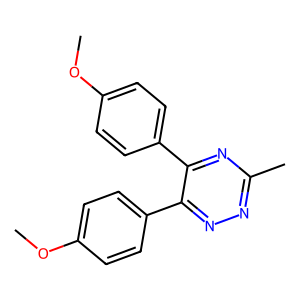


Top 10 Most Impactful Bits:

Bits with structural information:

Bit 123:
Tanimoto Similarity: 0.9615
Times Flipped: 1


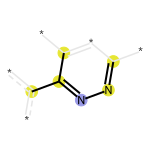


Bit 139:
Tanimoto Similarity: 0.9615
Times Flipped: 1


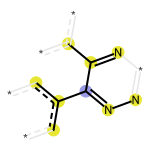


Bit 269:
Tanimoto Similarity: 0.9615
Times Flipped: 1


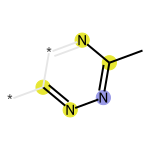


Bit 322:
Tanimoto Similarity: 0.9615
Times Flipped: 1


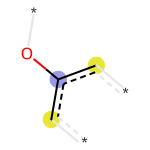


Bit 323:
Tanimoto Similarity: 0.9615
Times Flipped: 1


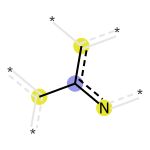


Bit 357:
Tanimoto Similarity: 0.9615
Times Flipped: 1


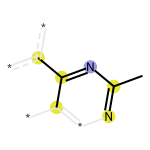


Bit 378:
Tanimoto Similarity: 0.9615
Times Flipped: 1


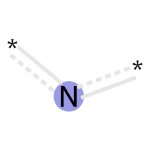


Bit 454:
Tanimoto Similarity: 0.9615
Times Flipped: 1


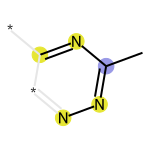


Bit 471:
Tanimoto Similarity: 0.9615
Times Flipped: 1


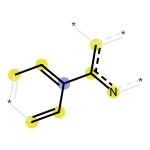


Bit 695:
Tanimoto Similarity: 0.9615
Times Flipped: 1


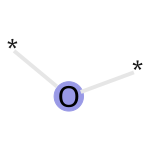

In [173]:
for molecule in ['anitrazafen']:
    analyze_single_molecule(dataframes_dict, molecule, 2048)
    print("\n" + "="*50 + "\n")

In [174]:
def analyze_all_molecules(dataframes_dict, n_flips_filter=None):
    """
    Analyze SMILES strings across all molecules and flip counts
    """
    print("Analysis of Generated Molecules Across All Datasets:\n")
    all_results = {}
    
    for molecule_name, flip_dict in dataframes_dict.items():
        # Skip molecules if they don't have the specified flip count
        if n_flips_filter is not None and n_flips_filter not in flip_dict:
            continue
            
        print(f"\n{'='*50}")
        print(f"Analysis for {molecule_name.upper()}")
        print(f"{'='*50}\n")
        
        for n_flips, df in flip_dict.items():
            if n_flips_filter is not None and n_flips != n_flips_filter:
                continue
                
            print(f"\n{'-'*30}")
            print(f"Number of Bits Flipped: {n_flips}")
            print(f"{'-'*30}")
            
            # Get unique SMILES for this dataset
            unique_smiles = df['Generated_SMILES'].unique()
            
            # Analyze this specific dataset
            results_df = analyze_smiles_differences(unique_smiles, df)
            
            # Store results
            all_results[f"{molecule_name}_{n_flips}"] = results_df
    
    return all_results

def analyze_smiles_differences(smiles_list, full_dataset):
    """
    Analyze a list of SMILES strings and return detailed molecular information
    """
    results = []
    
    # Calculate frequencies from the full dataset
    total_count = len(full_dataset)
    smiles_counts = full_dataset['Generated_SMILES'].value_counts()
    
    # Create a mapping of SMILES to their associated flipped bits
    smiles_to_bits = {}
    for smiles in smiles_list:
        relevant_rows = full_dataset[full_dataset['Generated_SMILES'] == smiles]
        flipped_bits = sorted(relevant_rows['FlippedBitPosition'].unique())
        smiles_to_bits[smiles] = flipped_bits
    
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f"Warning: Could not parse SMILES: {smiles}")
            continue
            
        # Calculate properties
        formula = Chem.rdMolDescriptors.CalcMolFormula(mol)
        mw = Descriptors.ExactMolWt(mol)
        logp = Descriptors.MolLogP(mol)
        hbd = Descriptors.NumHDonors(mol)
        hba = Descriptors.NumHAcceptors(mol)
        rotatable_bonds = Descriptors.NumRotatableBonds(mol)
        rings = Descriptors.RingCount(mol)
        aromatic_rings = sum(1 for ring in mol.GetRingInfo().AtomRings() 
                           if all(mol.GetAtomWithIdx(i).GetIsAromatic() for i in ring))
        
        # Calculate frequency
        count = smiles_counts.get(smiles, 0)
        frequency = (count / total_count) * 100
        
        results.append({
            'SMILES': smiles,
            'Molecular Formula': formula,
            'Molecular Weight': f"{mw:.2f}",
            'LogP': f"{logp:.2f}",
            'H-Bond Donors': hbd,
            'H-Bond Acceptors': hba,
            'Rotatable Bonds': rotatable_bonds,
            'Total Rings': rings,
            'Aromatic Rings': aromatic_rings,
            'Count': count,
            'Frequency': f"{frequency:.2f}%",
            'Flipped Bits': smiles_to_bits[smiles]
        })
    
    # Convert to DataFrame and sort by frequency
    df = pd.DataFrame(results)
    df = df.sort_values('Count', ascending=False)
    
    # Print summary
    for idx, row in df.iterrows():
        print(f"\nMolecule {idx + 1}:")
        print(f"SMILES: {row['SMILES']}")
        print(f"Formula: {row['Molecular Formula']}")
        print(f"Frequency: {row['Frequency']}")
        print(f"Flipped Bits: {', '.join(map(str, row['Flipped Bits']))}")
        print(f"MW: {row['Molecular Weight']} g/mol")
        print(f"LogP: {row['LogP']}")
        print(f"H-Bond Donors/Acceptors: {row['H-Bond Donors']}/{row['H-Bond Acceptors']}")
        print(f"Rotatable Bonds: {row['Rotatable Bonds']}")
        print(f"Rings (Total/Aromatic): {row['Total Rings']}/{row['Aromatic Rings']}")
        print()
    
    return df

In [175]:
# Analyze for flip counts of 2048 bit flips
analyses_2048 = analyze_all_molecules(dataframes_dict, n_flips_filter=2048)

Analysis of Generated Molecules Across All Datasets:


Analysis for ANITRAZAFEN


------------------------------
Number of Bits Flipped: 2048
------------------------------

Molecule 1:
SMILES: COc1ccc(-c2nnc(C)nc2-c2ccc(OC)cc2)cc1
Formula: C18H17N3O2
Frequency: 99.32%
Flipped Bits: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 